<a href="https://colab.research.google.com/github/Anurada23/Code-Of-Duty/blob/model_upgrade%2Fgayantha/upgrade_ml_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nuttidalapthanachai/nails-new-test

 25% 5.00M/19.7M [00:00<00:00, 35.7MB/s]
100% 19.7M/19.7M [00:00<00:00, 91.4MB/s]


In [ ]:
!unzip nails-new-test.zip -d disease

Archive:  nails-new-test.zip
  inflating: disease/beau's line/1 (1).jpg  
  inflating: disease/beau's line/1 (10).jpg  
  inflating: disease/beau's line/1 (100).jpg  
  inflating: disease/beau's line/1 (11).jpg  
  inflating: disease/beau's line/1 (12).jpg  
  inflating: disease/beau's line/1 (13).jpg  
  inflating: disease/beau's line/1 (14).jpg  
  inflating: disease/beau's line/1 (15).jpg  
  inflating: disease/beau's line/1 (16).jpg  
  inflating: disease/beau's line/1 (17).jpg  
  inflating: disease/beau's line/1 (18).jpg  
  inflating: disease/beau's line/1 (19).jpg  
  inflating: disease/beau's line/1 (2).jpg  
  inflating: disease/beau's line/1 (20).jpg  
  inflating: disease/beau's line/1 (21).jpg  
  inflating: disease/beau's line/1 (22).jpg  
  inflating: disease/beau's line/1 (23).jpg  
  inflating: disease/beau's line/1 (24).jpg  
  inflating: disease/beau's line/1 (25).jpg  
  inflating: disease/beau's line/1 (26).jpg  
  inflating: disease/beau's line/1 (27).jpg  
  infl

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
!pip install tensorflow==2.9.1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 42.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uni

In [ ]:
# function provides a quick way to visualize a sample batch of images and their predicted classes generated by a data generator

def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
            print(msg)
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)      
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)            
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print(msg)                    
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)               
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)                        
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print(msg)

In [ ]:
#showing training and validation Losse

def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
#The function then generates a confusion matrix and classification report based on the true labels and predicted classes.

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg)

                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print(msg)
        if errors>0:
            plot_bar=[]
            plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
# this function saving trained model
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    print ('the save path is: ', save_path)
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print ('model was saved as ' + model_save_loc) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print('class csv file was saved as ' + csv_save_loc) 

    # Convert SavedModel menjadi satelliteimageclassification.tflite
    
    return model_save_loc, csv_save_loc

In [ ]:
#Trim a pandas DataFrame so that each group in a specified column has no more than max_size samples and at least min_size samples.
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [ ]:
# This function balances the number of samples in each class of a training dataset by creating
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 


In [ ]:
#  Given a source directory containing subdirectories of images, this function preprocesses the images
#     and returns three dataframes for training, validation, and testing sets.
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)            
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df= train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
     # check that each dataframe has the same number of classes to prevent model.fit errors
    trcount=len(train_df['labels'].unique())
    tecount=len(test_df['labels'].unique())
    vcount=len(valid_df['labels'].unique())
    if trcount < tecount :         
        msg='** WARNING ** number of classes in training set is less than the number of classes in test set'
        print(msg)
        msg='This will throw an error in either model.evaluate or model.predict'
        print(msg)
    if trcount != vcount:
        msg='** WARNING ** number of classes in training set not equal to number of classes in validation set' 
        print(msg)
        msg=' this will throw an error in model.fit'
        print(msg)
        print ('train df class count: ', trcount, 'test df class count: ', tecount, ' valid df class count: ', vcount) 
        ans=input('Enter C to continue execution or H to halt execution')
        if ans =='H' or ans == 'h':
            print('Halting Execution')
            import sys
            sys.exit('program halted by user')            
    print(list(train_df['labels'].value_counts()))
    return train_df, test_df, valid_df


In [ ]:
sdir=r'/content/disease'
trsplit=.8
vsplit=.1
train_df, test_df, valid_df= preprocess(sdir,trsplit, vsplit)

train_df length:  560   test_df length:  70   valid_df length:  70
[80, 80, 80, 80, 80, 80, 80]


In [ ]:
max_samples= 150
min_samples=0
column='labels'
working_dir = r'./'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  7
[80, 80, 80, 80, 80, 80, 80]
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Total Augmented images created=  490
[150, 150, 150, 150, 150, 150, 150]


In [ ]:
channels=3
batch_size=40
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  70   test steps:  1
Found 1050 validated image filenames belonging to 7 classes.
Found 70 validated image filenames belonging to 7 classes.
Found 70 validated image filenames belonging to 7 classes.


In [ ]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=15# number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     9.846   32.667   9.35768  44.286   0.00100  0.00100  accuracy     0.00    53.01  
 2 /40     8.154   66.000   8.67513  55.714   0.00100  0.00100  accuracy    102.04   20.30  
 3 /40     7.202   83.619   7.74744  65.714   0.00100  0.00100  accuracy    26.70    20.01  
 4 /40     6.663   90.667   7.20667  72.857   0.00100  0.00100  val_loss     6.98    19.99  
 5 /40     6.169   95.143   6.64819  75.714   0.00100  0.00100  val_loss     7.75    20.20  
 6 /40     5.765   96.857   6.16954  77.143   0.00100  0.00100  val_loss     7.20    19.99  
 7 /40     5.419   96.952   5.78750  78.571   0.00100  0.00100  val_loss     6.19    19.97  
 8 /40     5.062   98.190   5.48144  80.000   0.00100  0.00100  val_loss     5.29    19.98  
 9 /40     4.754   98.286   5.11965  80.000   0.00100  0.00100  val_loss     6.60    19.91  
10 /40     4.447   98.857   4.80730  84.286   0.00100  0.00100  val_los

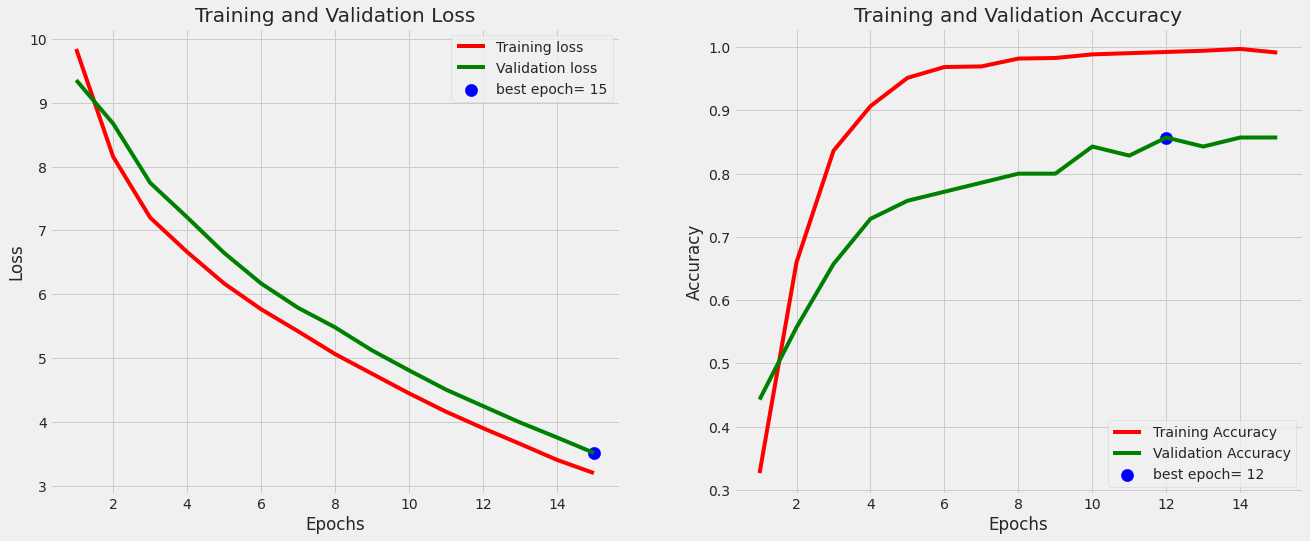

1/1 [==============================] - 0s 462ms/step - loss: 3.3601 - accuracy: 0.9000
accuracy on the test set is 90.00 %
the save path is:  ./
model was saved as ./EfficientNetB3-nails-89.99.h5
class csv file was saved as ./class_dict.csv


In [ ]:
tr_plot(history,0)
subject='nails'
acc=model.evaluate( test_gen, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

1/1 [==============================] - 0s 207ms/step


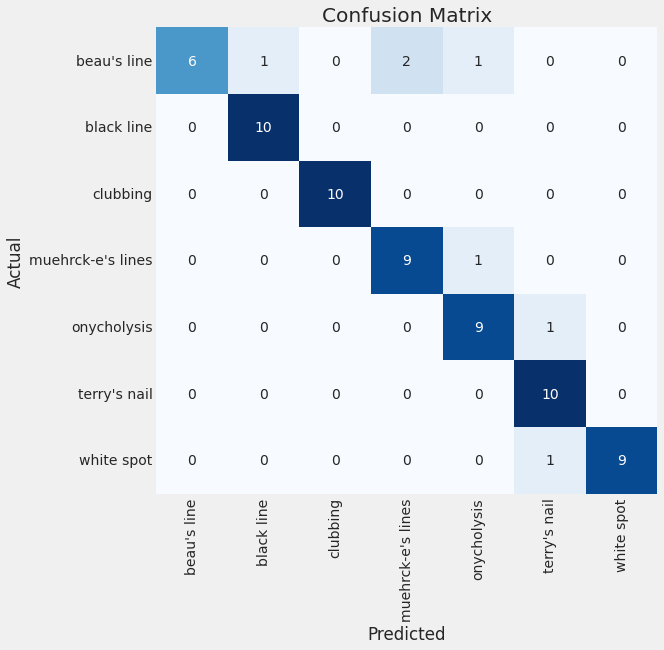

Classification Report:
----------------------
                    precision    recall  f1-score   support

      beau's line       1.00      0.60      0.75        10
       black line       0.91      1.00      0.95        10
         clubbing       1.00      1.00      1.00        10
muehrck-e's lines       0.82      0.90      0.86        10
      onycholysis       0.82      0.90      0.86        10
     terry's nail       0.83      1.00      0.91        10
       white spot       1.00      0.90      0.95        10

         accuracy                           0.90        70
        macro avg       0.91      0.90      0.90        70
     weighted avg       0.91      0.90      0.90        70



In [ ]:
print_code=0
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, subject )  

Input image shape is  (173, 220, 3)
the resized image has shape  (224, 224, 3)
image shape after expanding dimensions is  (1, 224, 224, 3)
1/1 [==============================] - 0s 51ms/step
 the shape of prediction is  (1, 7)
the image is predicted as being  black line  with a probability of  28.738096356391907


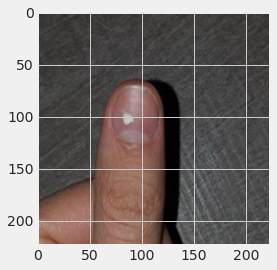

In [ ]:
fpath=r'/content/drive/MyDrive/gayantha/220px-White_spot_in_nail.jpg'
img=plt.imread(fpath)
print ('Input image shape is ', img.shape)
# resize the image so it is the same size as the images the model was trained on
img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
print ('the resized image has shape ', img.shape)
### show the resized image
plt.imshow(img)
# Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# img= img/255
# plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# where the first dimension 1 is the batch size used by model.predict
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
# now predict the image
pred=model.predict(img)
print (' the shape of prediction is ', pred.shape)
# this dataset has 15 classes so model.predict will return a list of 15 probability values
# we want to find the index of the column that has the highest probability
index=np.argmax(pred[0])
# to get the actual Name of the class earlier Imade a list of the class names called classes
klass=classes[index]
# lets get the value of the highest probability
probability=pred[0][index]*100
# print out the class, and the probability 
print('the image is predicted as being ', klass, ' with a probability of ', probability)

In [ ]:
# load model and and use
def test_img(img):
  model_path = '/content/EfficientNetB3-nails-89.99.h5'
  img_size = (224, 224)
  fpath=img
  img=plt.imread(fpath)
  print ('Input image shape is ', img.shape)
  # resize the image so it is the same size as the images the model was trained on
  img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
  print ('the resized image has shape ', img.shape)
  ### show the resized image
  # plt.imshow(img)
  # Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
  # plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
  # since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
  # where the first dimension 1 is the batch size used by model.predict
  img=np.expand_dims(img, axis=0)
  print ('image shape after expanding dimensions is ',img.shape)
  # now predict the image
  pred=model.predict(img)
  print (' the shape of prediction is ', pred.shape)
  # this dataset has 15 classes so model.predict will return a list of 15 probability values
  # we want to find the index of the column that has the highest probability
  index=np.argmax(pred[0])
  # to get the actual Name of the class earlier Imade a list of the class names called classes
  klass=classes[index]
  
  # lets get the value of the highest probability
  probability = pred[0][index] * 100
  if probability < 30:
      print("Try again.")
  else:
      # Print out the class and the probability.
      print('The image is predicted as being', klass, 'with a probability of', probability)





In [ ]:
test_img('/content/drive/MyDrive/gayantha/download.jpeg')

Input image shape is  (192, 256, 3)
the resized image has shape  (224, 224, 3)
image shape after expanding dimensions is  (1, 224, 224, 3)
1/1 [==============================] - 0s 55ms/step
 the shape of prediction is  (1, 7)
beau's line
black line
clubbing
muehrck-e's lines
onycholysis
terry's nail
white spot
The image is predicted as being white spot with a probability of 93.36597323417664


In [ ]:
!cp /content/EfficientNetB3-nails-89.99.h5 /content/drive/MyDrive